# Decision Tree Analysis for Fitness Class Attendance

This notebook demonstrates building and optimizing a Decision Tree Classifier for predicting fitness class attendance.

In [30]:
# Package installation and import handler
import subprocess
import sys
import importlib

def install_package(package_name):
    print(f"⚙ Installing {package_name}...")
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package_name])
        return True
    except subprocess.CalledProcessError as e:
        print(f"✗ Error installing {package_name}: {str(e)}")
        return False

# Package mapping (pip install name -> import name)
PACKAGE_MAPPING = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'scikit-learn': 'sklearn',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn'
}

# Install and import required packages
for pip_name, import_name in PACKAGE_MAPPING.items():
    try:
        # Try importing first
        module = importlib.import_module(import_name)
        print(f"✓ {pip_name} is already installed")
    except ImportError:
        # Install if import fails
        if install_package(pip_name):
            try:
                module = importlib.import_module(import_name)
                print(f"✓ Successfully installed and imported {pip_name}")
            except ImportError as e:
                print(f"✗ Error importing {pip_name} after installation: {str(e)}")
                raise

# Import specific modules after ensuring packages are installed
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("\n✓ All required packages imported successfully!")

✓ pandas is already installed
✓ numpy is already installed
✓ scikit-learn is already installed
✓ matplotlib is already installed
✓ seaborn is already installed

✓ All required packages imported successfully!


In [31]:
# Load and preprocess the dataset
def preprocess_data(df):
    # Handle missing values
    df['weight'] = df['weight'].fillna(df['weight'].mean())
    
    # Clean day_of_week values
    day_mapping = {
        'Monday': 'Mon', 'Mon.': 'Mon', 'Monday,': 'Mon',
        'Tuesday': 'Tue', 'Tue.': 'Tue', 'Tuesday,': 'Tue',
        'Wednesday': 'Wed', 'Wed.': 'Wed', 'Wednesday,': 'Wed',
        'Thursday': 'Thu', 'Thu.': 'Thu', 'Thursday,': 'Thu',
        'Friday': 'Fri', 'Fri.': 'Fri', 'Friday,': 'Fri',
        'Saturday': 'Sat', 'Sat.': 'Sat', 'Saturday,': 'Sat',
        'Sunday': 'Sun', 'Sun.': 'Sun', 'Sunday,': 'Sun'
    }
    df['day_of_week'] = df['day_of_week'].replace(day_mapping)
    
    # Convert days_before to numeric
    df['days_before'] = pd.to_numeric(df['days_before'].str.extract('(\d+)', expand=False))
    
    return df

# Load data
df = pd.read_csv('fitness_class_2212.csv')
df = preprocess_data(df)

# Encode categorical variables
le = LabelEncoder()
categorical_cols = ['day_of_week', 'time', 'category']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].fillna('-'))

# Select features
feature_cols = ['months_as_member', 'weight', 'days_before', 'day_of_week', 'time', 'category']
X = df[feature_cols]
y = df['attended']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
# Create and evaluate multiple decision tree models
models = {
    'Default': DecisionTreeClassifier(random_state=42),
    'Entropy': DecisionTreeClassifier(criterion='entropy', random_state=42),
    'Pruned': DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42),
    'Optimized': DecisionTreeClassifier(
        criterion='entropy',
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': classification_report(y_test, y_pred)
    }
    
    print(f'\n{name} Model Results:')
    print(f'Accuracy: {accuracy:.4f}')
    print('\nClassification Report:')
    print(results[name]['report'])


Default Model Results:
Accuracy: 0.6711

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       293
           1       0.53      0.50      0.51       157

    accuracy                           0.67       450
   macro avg       0.63      0.63      0.63       450
weighted avg       0.67      0.67      0.67       450


Entropy Model Results:
Accuracy: 0.6911

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       293
           1       0.57      0.49      0.53       157

    accuracy                           0.69       450
   macro avg       0.66      0.64      0.65       450
weighted avg       0.68      0.69      0.69       450


Pruned Model Results:
Accuracy: 0.7267

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       293
           1       0.65      0.46      0.54

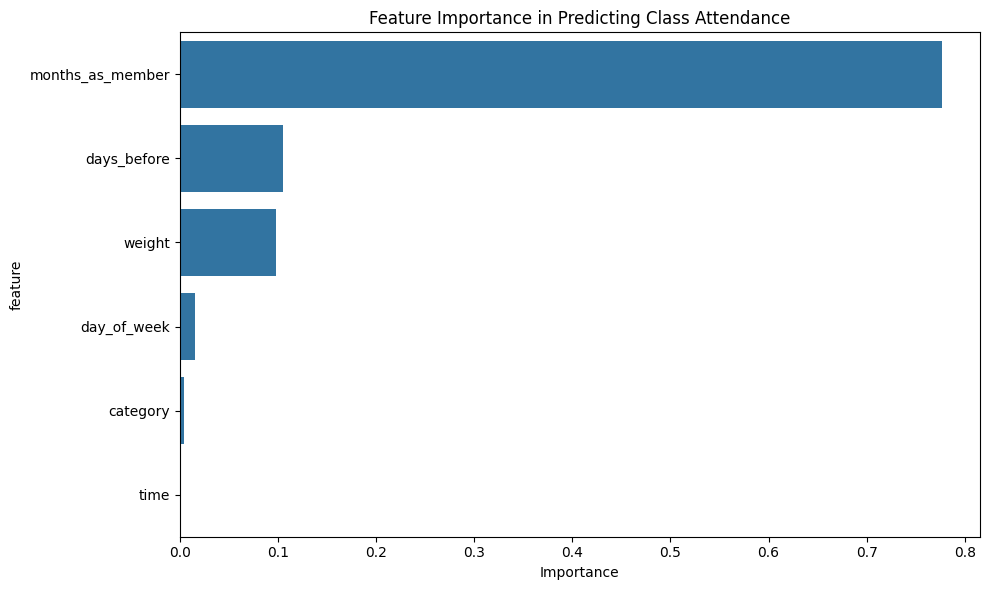

In [33]:
# Visualize feature importance for the best model
best_model = results['Optimized']['model']

# Create feature importance plot
importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importances)
plt.title('Feature Importance in Predicting Class Attendance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

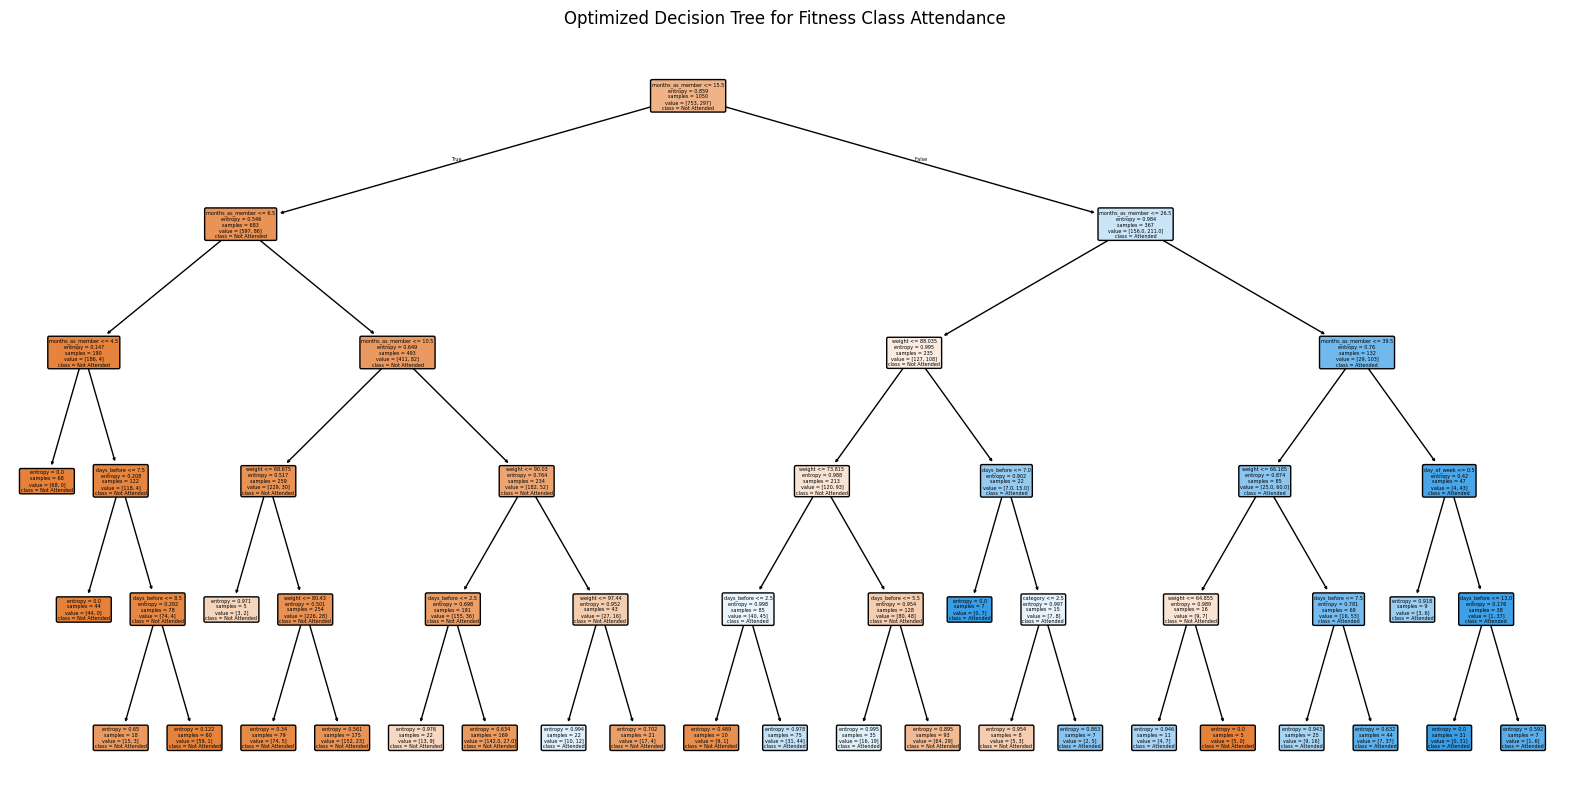


Text Representation of the Decision Tree:
|--- months_as_member <= 15.50
|   |--- months_as_member <= 6.50
|   |   |--- months_as_member <= 4.50
|   |   |   |--- class: 0
|   |   |--- months_as_member >  4.50
|   |   |   |--- days_before <= 7.50
|   |   |   |   |--- class: 0
|   |   |   |--- days_before >  7.50
|   |   |   |   |--- days_before <= 8.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- days_before >  8.50
|   |   |   |   |   |--- class: 0
|   |--- months_as_member >  6.50
|   |   |--- months_as_member <= 10.50
|   |   |   |--- weight <= 68.68
|   |   |   |   |--- class: 0
|   |   |   |--- weight >  68.68
|   |   |   |   |--- weight <= 80.43
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- weight >  80.43
|   |   |   |   |   |--- class: 0
|   |   |--- months_as_member >  10.50
|   |   |   |--- weight <= 90.03
|   |   |   |   |--- days_before <= 2.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- days_before >  2.50
|   |   |   |   |   |--- class: 0
|  

In [34]:
# Visualize the optimized decision tree
plt.figure(figsize=(20,10))
plot_tree(best_model, 
          feature_names=feature_cols,
          class_names=['Not Attended', 'Attended'],
          filled=True,
          rounded=True)
plt.title('Optimized Decision Tree for Fitness Class Attendance')
plt.show()

# Print text representation of the tree
print('\nText Representation of the Decision Tree:')
print(export_text(best_model, feature_names=feature_cols))